<a href="https://colab.research.google.com/github/shpark02084/TensorFlow/blob/main/computer_vision_food_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to build a deep learning model to beat the original Food-101 Mining Discriminative Components with Random Forests, 50.67% accuracy. \\
[Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) 


|  | 🍔👁 Food Vision|
|-----|-----|
| Dataset source | TensorFlow Datasets | 
| Train data | 75,750 images | 
| Test data | 25,250 images | 
| Data loading | Performanant tf.data API | 
| Target results |   50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 



Following steps


1.   Using TensorFlow Datasets to download and explore data
2.   Creating preprocessing function for our data
3.   Batching & preparing datasets for modelling
4. Creating modelling callbakcs
5. Setting up mixed precision training
6. Building a Fine-tuning the feature extraction model





In [ ]:
# Check GPU
!nvidia-smi 
import tensorflow as tf 


Sat Apr  2 02:06:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get functions

!wget https://raw.githubusercontent.com/shpark02084/helper_function/main/functions.py


--2022-04-02 01:41:39--  https://raw.githubusercontent.com/shpark02084/helper_function/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-02 01:41:39 (106 MB/s) - ‘functions.py’ saved [10246/10246]



## **1. Using TensorFlow Datasets to download and explore data**

In [ ]:
#import functions
from functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Load food101 data
(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, 
                                             with_info=True)
 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteI8K92L/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteI8K92L/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Get data info 
ds_info.features



FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get first 10 class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
# What does one sample of our training data look like?
train_one_sample
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


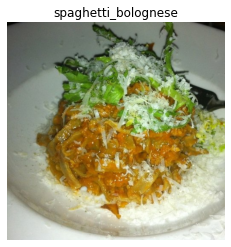

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **2. Creating preprocessing function for our data**

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label 

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.586735  12.586735   6.586735 ]
  [11.714286  12.714286   6.714286 ]
  [ 8.857142   9.857142   4.8571424]
  ...
  [20.714308  11.142836   1.2857144]
  [20.668371  10.668372   0.       ]
  [21.        11.         0.       ]]

 [[ 2.3571415  3.3571415  0.1428566]
  [ 3.1530607  4.1530604  0.0765303]
  [ 3.0561223  4.0561223  0.       ]
  ...
  [26.071407  18.071407   7.0714073]
  [24.785702  14.785702   4.7857018]
  [22.499966  12.499966   2.4999657]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


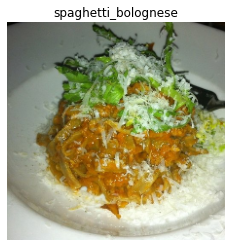

In [ ]:
# Plot preprocessed image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## **3. Batching & preparing datasets for modelling**

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## **4. Creating modelling callbakcs**

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" 
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", 
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1) 

## **5. Setting up mixed precision training**

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 
mixed_precision.global_policy()

<Policy "mixed_float16">

## **6. Building a fine-tuning and feature extraction model**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)

x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Fit the model with callbacks
history_feature_extract = model.fit(train_data, 
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", 
                                                                          "efficientnetb0_101_classes_all_data_feature_extract"),
                                    model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220402-024836
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 0.7737 - accuracy: 0.7960
Epoch 1: val_loss did not improve from 1.05960
2368/2368 [==============================] - 158s 66ms/step - loss: 0.7737 - accuracy: 0.7960 - val_loss: 1.0740 - val_accuracy: 0.7060
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.7426 - accuracy: 0.8048
Epoch 2: val_loss did not improve from 1.05960
2368/2368 [==============================] - 164s 69ms/step - loss: 0.7425 - accuracy: 0.8048 - val_loss: 1.0928 - val_accuracy: 0.7121
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.8106
Epoch 3: val_loss did not improve from 1.05960
2368/2368 [==============================] - 168s 70ms/step - loss: 0.7164 - accuracy: 0.8106 - val_loss: 1.1059 - val_accuracy: 0.7087


In [ ]:
# Evaluate feature_extract_model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 48s 61ms/step - loss: 1.0875 - accuracy: 0.7079


[1.0874512195587158, 0.7079207897186279]

Load and Evaluate checkpoint weights

1.   Cloning the model
2.   load_weights()
3. evaluate()



In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
!ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 57s 66ms/step - loss: 1.7266 - accuracy: 0.5466


In [ ]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: efficientnetb0_feature_extract_model_mixed_precision/assets


Add more callbacks


In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
                        optimizer=tf.keras.optimizers.Adam(0.0001), 
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220402-030635
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7405 - accuracy: 0.7920INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 386s 157ms/step - loss: 0.7405 - accuracy: 0.7920 - val_loss: 0.9139 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 323s 135ms/step - loss: 0.4346 - accuracy: 0.8754 - val_loss: 1.0432 - val_accuracy: 0.7450 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9297
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 325s 137ms/step - loss: 0.2403 - accuracy: 0.9297 - val_loss: 1.0874 - val_accuracy: 0.7561 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 328s 138ms/step - loss: 0.0539 - accuracy: 0.9869 - val_loss: 1.1443 - val_accuracy: 0.7730 - lr: 2.0000e-05


In [ ]:
model.save("fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: fine_tuned_101_classes_mixed_precision/assets


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 47s 59ms/step - loss: 1.1047 - accuracy: 0.7757


[1.1046937704086304, 0.7757228016853333]